#Seria-A Prediction


In [205]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW

In [206]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
# #Reading the dataset
file_path = '/content/drive/My Drive/I1.csv'
df = pd.read_csv(file_path)

In [208]:
# file_path = '/content/I1.csv'
# df = pd.read_csv(file_path)
#printing few rows of the dataset
print(df.head())
print(df.info())
print(df.isnull().sum()[df.isnull().sum() > 0])

  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92      2.01   1.91   2.02     1.94     2.05   
4  ...     1.68 -1.00      1.95      1.98   1.94   1.98     2.03     2.03   

   AvgCAHH  AvgCAHA  
0     1.94     1.90  
1     1.95  

In [209]:
# Droping rows with missing target values
df.dropna(subset=['FTR'], inplace=True)

# Separating numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Filling missing values in numeric columns with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Filling missing values in non-numeric columns with mode
for col in df.columns:df[col].fillna(df[col].mode()[0], inplace=True)

# Checking if there are any missing values left
print(df.isnull().sum())

print(df.head())




Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
PCAHA       0
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
Length: 105, dtype: int64
  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92

In [210]:
#Getting day on which match was played from the matchDate and strong that in matchDay column
df["matchDate"] = pd.to_datetime( df["Date"], dayfirst=True)
df['matchDay'] = df['matchDate'].dt.day_name()
df.drop('Date', axis=1, inplace=True)
df.drop('matchDate', axis=1, inplace=True)

df.head()

<ipython-input-210-71caf1ad4bf4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['matchDay'] = df['matchDate'].dt.day_name()


,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,matchDay
0,I1,17:30,Empoli,Verona,0,1,A,0,0,D,...,-0.25,2.02,1.91,2.01,1.92,2.03,1.98,1.94,1.90,Saturday
1,I1,17:30,Frosinone,Napoli,1,3,A,1,2,A,...,1.00,1.96,1.97,1.97,1.95,2.02,1.98,1.95,1.89,Saturday
2,I1,19:45,Genoa,Fiorentina,1,4,A,0,3,A,...,0.25,1.79,2.15,1.82,2.13,2.02,2.15,1.86,2.00,Saturday
3,I1,19:45,Inter,Monza,2,0,H,1,0,H,...,-1.25,1.92,2.01,1.91,2.02,1.94,2.05,1.87,1.98,Saturday
4,I1,17:30,Roma,Salernitana,2,2,D,1,1,D,...,-1.00,1.95,1.98,1.94,1.98,2.03,2.03,1.92,1.93,Sunday


In [211]:
#keywords to drop
keywords_drop = ['B365', 'BW', 'IW', 'PS', 'WH', 'VC', 'Max', 'Avg', 'P>2.5', 'P<2.5', 'AHh', 'AHH', 'AHA', 'CH', 'CD', 'CA', 'C>2.5', 'C<2.5','AHCh']

# Creating a list of columns to drop
columns_to_drop = [col for col in df.columns if any(keyword in col for keyword in keywords_drop)]
df = df.drop(columns=columns_to_drop)

#one hot encoding for the below attributes
df = pd.get_dummies(df, columns=['HomeTeam'], prefix = ['HomeTeam'],dtype=int)
df = pd.get_dummies(df, columns=['AwayTeam'], prefix = ['AwayTeam'],dtype=int)
df = pd.get_dummies(df, columns=['HTR'], prefix = ['HTR'],dtype=int)
df = pd.get_dummies(df, columns=['matchDay'], prefix = ['matchDay'],dtype=int)
print(df.head())

#label encoding of the attribute FTR(target attribute)
label_encoder = LabelEncoder()
df['FTR']= label_encoder.fit_transform(df['FTR'])

  Div   Time  FTHG  FTAG FTR  HTHG  HTAG  HS  AS  HST  ...  HTR_A  HTR_D  \
0  I1  17:30     0     1   A     0     0  10  10    4  ...      0      1   
1  I1  17:30     1     3   A     1     2   4  19    1  ...      1      0   
2  I1  19:45     1     4   A     0     3   4   9    2  ...      1      0   
3  I1  19:45     2     0   H     1     0  22  12    3  ...      0      0   
4  I1  17:30     2     2   D     1     1  13   3    3  ...      0      1   

   HTR_H  matchDay_Friday  matchDay_Monday  matchDay_Saturday  \
0      0                0                0                  1   
1      0                0                0                  1   
2      0                0                0                  1   
3      1                0                0                  1   
4      0                0                0                  0   

   matchDay_Sunday  matchDay_Thursday  matchDay_Tuesday  matchDay_Wednesday  
0                0                  0                 0                   

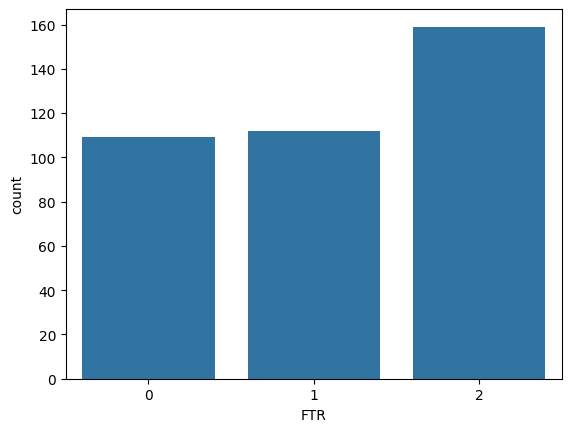

In [212]:

sns.countplot(x='FTR',data=df)

X = df.drop(['FTR','Div','Time'],axis=1)
y = df['FTR']

X_standardized = StandardScaler().fit_transform(X)


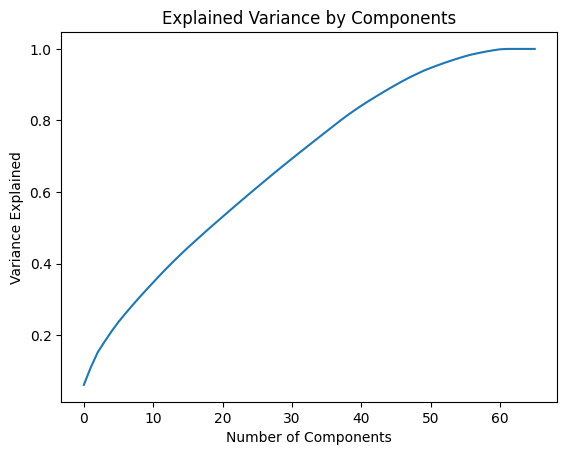

In [213]:

# Apply PCA to determine the optimal number of components
pca = PCA().fit(X_standardized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Components')
plt.show()


In [214]:
#Taking 60 components from training
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_standardized)

In [215]:
# Split the dataset. 80 % to training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print("The shape of X_train is " + str(X_train.shape))
print("The size of y_train is " + str(y_train.shape))
print("The size of X_test set is " + str(X_test.shape))
print("The size of y_test is " + str(y_test.shape))


The shape of X_train is (304, 60)
The size of y_train is (304,)
The size of X_test set is (76, 60)
The size of y_test is (76,)


Accuracy: 0.6447368421052632
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.62      0.20      0.30        25
           2       0.60      0.97      0.74        29

    accuracy                           0.64        76
   macro avg       0.66      0.63      0.59        76
weighted avg       0.65      0.64      0.60        76



<Axes: >

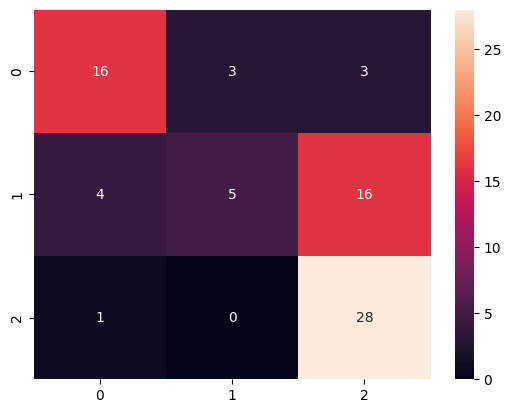

In [218]:
#training with random forest classifier
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


Accuracy: 0.6842105263157895
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.61      0.44      0.51        25
           2       0.69      0.86      0.77        29

    accuracy                           0.68        76
   macro avg       0.68      0.68      0.67        76
weighted avg       0.68      0.68      0.67        76



<Axes: >

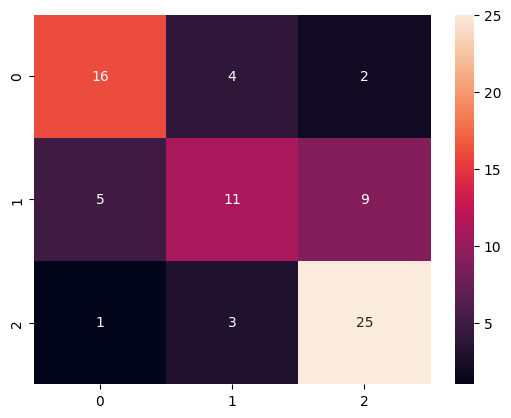

In [219]:
#training with gradient boost classifier
model_gb = GradientBoostingClassifier(n_estimators=200)
model_gb.fit(X_train, y_train)
y_pred=model_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [220]:
#chaning the target columns into categorical for classfication
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [221]:
#training with neural network
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with lower learning rate and gradient clipping
model2.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.0001),
    metrics=['accuracy']
)



In [222]:

# Define callbacks with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with increased batch size and callbacks
history = model2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.4201 - loss: 1.8434 - val_accuracy: 0.3115 - val_loss: 1.8456
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4133 - loss: 1.7865 - val_accuracy: 0.3115 - val_loss: 1.8327
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4726 - loss: 1.7491 - val_accuracy: 0.3115 - val_loss: 1.8213
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5099 - loss: 1.7388 - val_accuracy: 0.3115 - val_loss: 1.8122
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4658 - loss: 1.7273 - val_accuracy: 0.3115 - val_loss: 1.8040
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4921 - loss: 1.7395 - val_accuracy: 0.3279 - val_loss: 1.7953
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4712 - loss: 1.7116 - val_accuracy: 0.3443 - val_loss: 1.7872
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4981 - loss: 1.6969 - val_accuracy: 0.3607 - val_los

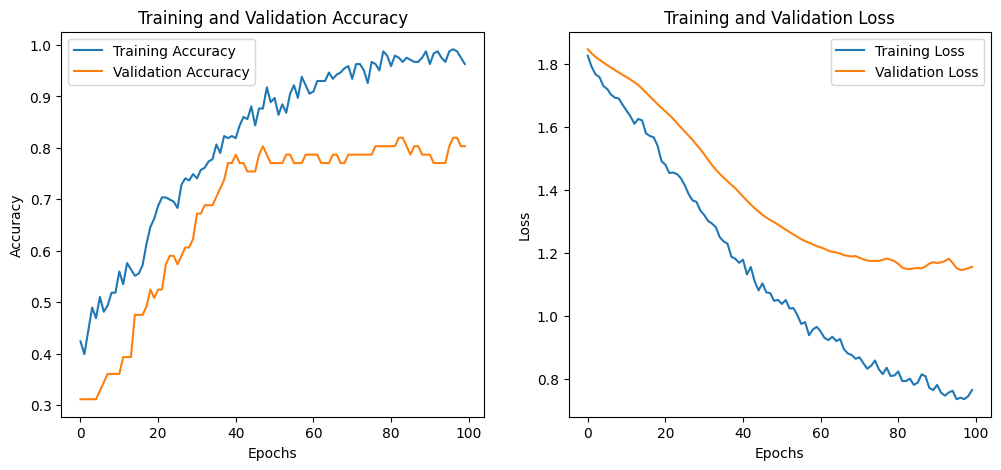

In [223]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [224]:
score = model2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7342 - loss: 1.3670 
Test Score: 1.4765130281448364
Test Accuracy: 0.7105262875556946


In [225]:
#generating classifcation report
y_pred = model2.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        22
           1       0.55      0.68      0.61        25
           2       0.81      0.76      0.79        29

    accuracy                           0.71        76
   macro avg       0.73      0.71      0.71        76
weighted avg       0.73      0.71      0.72        76



In [226]:
#predicting the result
row_index = 0  # selected row is 4. You can change it to the row number, you want to predict
Xnew = X_test[0].reshape(1,-1)
#predicing the output. Below line will give the probability
y_pred=model2.predict(Xnew)
#covert the probability to the predicted class
ynew = np.argmax(y_pred,axis=1)
print("Probability distribution is ",y_pred)
print("Predicted class label is ", ynew[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Probability distribution is  [[0.0152276  0.9707168  0.01405567]]
Predicted class label is  1


In [227]:
y_test[0]

array([0., 1., 0.])

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3169 - loss: 18.7068 - val_accuracy: 0.4262 - val_loss: 18.4736 - learning_rate: 1.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4145 - loss: 18.4287 - val_accuracy: 0.4918 - val_loss: 18.2417 - learning_rate: 1.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3984 - loss: 18.1678 - val_accuracy: 0.4590 - val_loss: 18.0151 - learning_rate: 1.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3920 - loss: 17.9746 - val_accuracy: 0.4590 - val_loss: 17.7905 - learning_rate: 1.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4968 - loss: 17.6905 - val_accuracy: 0.4590 - val_loss: 17.5670 - learning_rate: 1.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4971 - loss: 17.4509 - val_accuracy: 0.4590 - val_loss: 17.3428 - learning_rate: 1.0000e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.

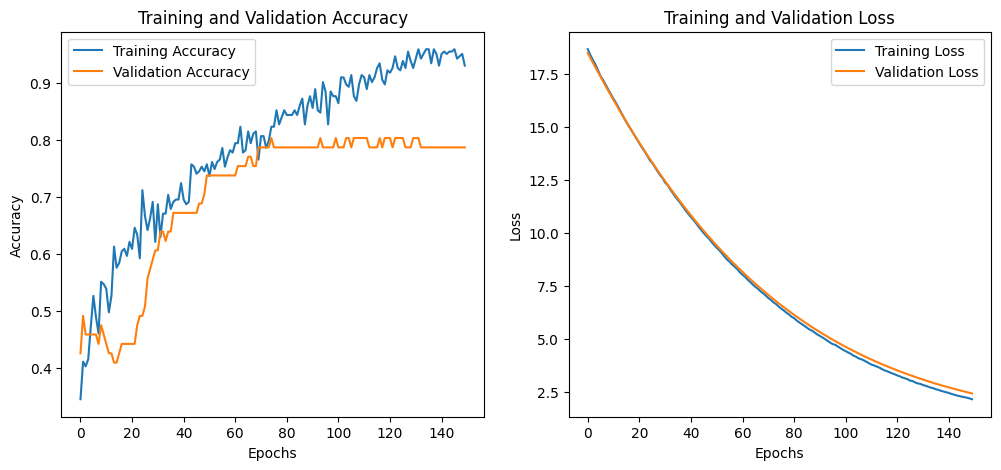

In [228]:
#sequential model with different parameter
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with the learning rate schedule
model6.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model6.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [229]:
#this model is better than other ones
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model6.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.62      0.60      0.61        25
           2       0.83      0.83      0.83        29

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2841 - loss: 8.4089 - val_accuracy: 0.4098 - val_loss: 8.1029 - learning_rate: 2.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3358 - loss: 8.1625 - val_accuracy: 0.4098 - val_loss: 7.9962 - learning_rate: 2.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3629 - loss: 8.0181 - val_accuracy: 0.4098 - val_loss: 7.8935 - learning_rate: 2.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4305 - loss: 7.8852 - val_accuracy: 0.3934 - val_loss: 7.7904 - learning_rate: 2.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4552 - loss: 7.7615 - val_accuracy: 0.3934 - val_loss: 7.6868 - learning_rate: 2.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5054 - loss: 7.6362 - val_accuracy: 0.3934 - val_loss: 7.5858 - learning_rate: 2.0000e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5155 - loss: 7.

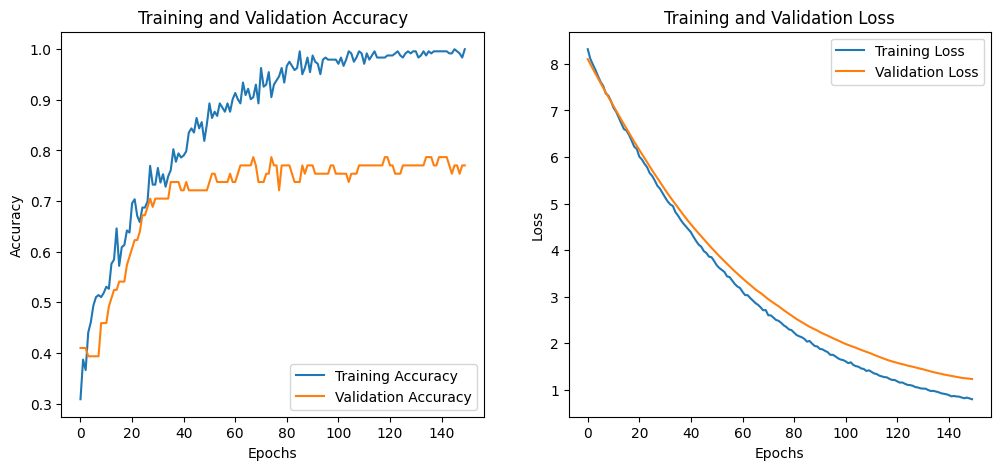

In [230]:
# Updated model architecture with different parameter
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Increased units
    tf.keras.layers.Dropout(0.2),  # Adjusted dropout
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Adjusted units
    tf.keras.layers.Dropout(0.3),  # Adjusted dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Adjusted units
    tf.keras.layers.Dropout(0.5),  # Adjusted dropout
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with AdamW optimizer and fixed learning rate
model9.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.0002, weight_decay=1e-5),  # Use fixed learning rate
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model9.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [231]:
#this model is better than other ones
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model9.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.61      0.68      0.64        25
           2       0.88      0.79      0.84        29

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.76      0.75      0.75        76



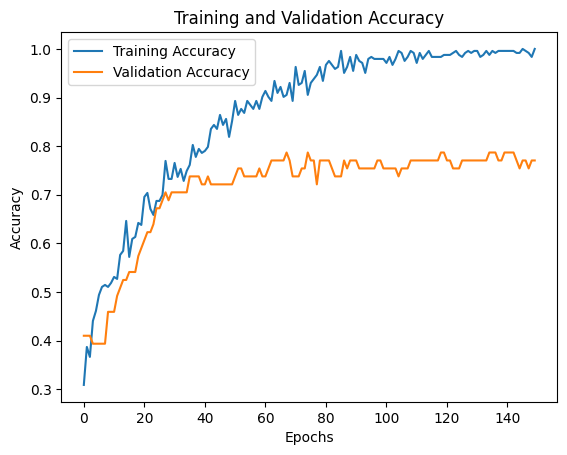

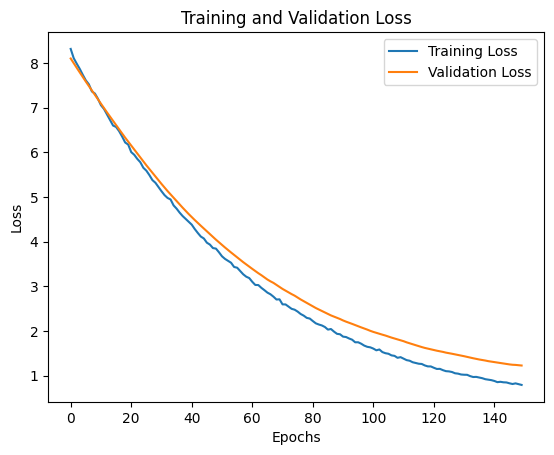

In [232]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [189]:
model9.summary()

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_337 (Dense)                    │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_253 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_338 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_254 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_339 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_255 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_340 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,891 (667.55 KB)

 Trainable params: 56,963 (222.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,928 (445.04 KB)

In [190]:
#predicting the result
row_index = 0  # selected row is 4. You can change it to the row number, you want to predict
Xnew = X_test[0].reshape(1,-1)
#predicing the output. Below line will give the probability
y_pred=model9.predict(Xnew)
#covert the probability to the predicted class
ynew = np.argmax(y_pred,axis=1)
print("Probability distribution is ",y_pred)
print("Predicted class label is ", ynew[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Probability distribution is  [[0.14399415 0.818799   0.03720684]]
Predicted class label is  1


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3294 - loss: 8.3161 - val_accuracy: 0.3443 - val_loss: 8.1057 - learning_rate: 2.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4704 - loss: 8.0705 - val_accuracy: 0.2951 - val_loss: 7.9844 - learning_rate: 2.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3926 - loss: 7.9970 - val_accuracy: 0.2787 - val_loss: 7.8707 - learning_rate: 2.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4243 - loss: 7.8261 - val_accuracy: 0.3115 - val_loss: 7.7608 - learning_rate: 2.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5070 - loss: 7.6344 - val_accuracy: 0.3279 - val_loss: 7.6561 - learning_rate: 2.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4982 - loss: 7.5799 - val_accuracy: 0.3279 - val_loss: 7.5463 - learning_rate: 2.0000e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5199 - loss: 7.46

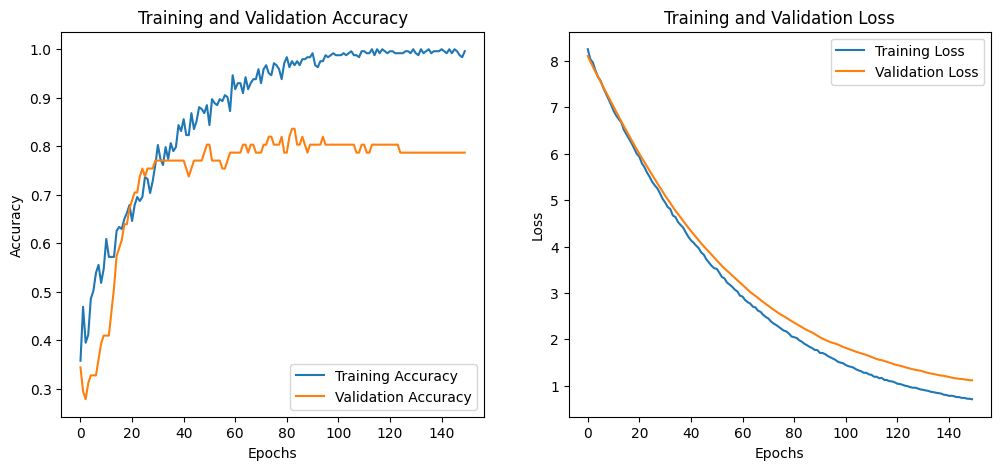

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.66      0.76      0.70        25
           2       0.88      0.79      0.84        29

    accuracy                           0.79        76
   macro avg       0.80      0.79      0.79        76
weighted avg       0.80      0.79      0.79        76



In [234]:
# Updated model architecture with different parameter
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Increased units
    tf.keras.layers.Dropout(0.2),  # Adjusted dropout
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Adjusted units
    tf.keras.layers.Dropout(0.3),  # Adjusted dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.02)),  # Adjusted units
    tf.keras.layers.Dropout(0.4),  # Adjusted dropout
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with AdamW optimizer and fixed learning rate
model10.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.0002, weight_decay=1e-5),  # Use fixed learning rate
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model10.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#this model is better than other ones
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model10.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

In [237]:
model10.summary()

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_382 (Dense)                    │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_287 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_383 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_288 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_384 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_289 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_385 (Dense)                    │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,891 (667.55 KB)

 Trainable params: 56,963 (222.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,928 (445.04 KB)

In [239]:
#predicting the result
row_index = 0  # selected row is 4. You can change it to the row number, you want to predict
Xnew = X_test[0].reshape(1,-1)
#predicing the output. Below line will give the probability
y_pred=model10.predict(Xnew)
#covert the probability to the predicted class
ynew = np.argmax(y_pred,axis=1)
print("Probability distribution is ",y_pred)
print("Predicted class label is ", ynew[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Probability distribution is  [[0.0824779  0.86911327 0.04840884]]
Predicted class label is  1
